# <font color="red">Icon Prediction with Random Forest</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

import sys
# sys.path.append('../../') # Uncomment this line if running locally
sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
# weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

,DateTime,Year,Month,Day,Hour,DaySegments,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,...,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy,Conditions,Icon
0,2023-01-01 00:00:00,2023,1,1,0,Late Night,0,0,0,1,...,0.49,1018.68,0.03,0.0,10.0,2.76,0.0,0.0,Clear,clear-night
1,2023-01-01 01:00:00,2023,1,1,1,Late Night,0,0,0,1,...,0.54,1018.03,0.11,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
2,2023-01-01 02:00:00,2023,1,1,2,Late Night,0,0,0,1,...,30.51,1017.56,0.03,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
3,2023-01-01 03:00:00,2023,1,1,3,Late Night,0,0,0,1,...,49.23,1018.05,0.00,0.0,10.0,2.28,0.0,0.0,Clear,clear-night
4,2023-01-01 04:00:00,2023,1,1,4,Late Night,0,0,0,1,...,49.90,1018.00,86.17,0.0,10.0,1.27,0.0,0.0,Partially cloudy,fog


In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

,DateTime,Year,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,DaySegments_Midday,...,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy
count,14616,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,...,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000
mean,2023-11-01 11:30:00,2023.400657,5.720854,15.735632,11.500000,0.131294,0.060550,0.098043,0.249726,0.116585,...,17.068560,8.090783,159.739178,1008.265012,53.579923,2.263555,16.504787,4.368134,227.640683,0.819217
min,2023-01-01 00:00:00,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.000000,0.000000,982.420000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,2023-06-02 05:45:00,2023.000000,3.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.170000,2.870000,80.965000,1003.277500,26.670000,0.000000,10.000000,3.990000,0.000000,0.000000
50%,2023-11-01 11:30:00,2023.000000,6.000000,16.000000,11.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.645000,7.670000,163.790000,1007.970000,51.540000,0.000000,10.000000,4.650000,10.665000,0.010000
75%,2024-04-01 17:15:00,2024.000000,8.000000,23.000000,17.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.410000,11.750000,241.402500,1013.400000,87.790000,4.740000,12.580000,4.650000,459.745000,1.660000
max,2024-08-31 23:00:00,2024.000000,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,84.120000,71.970000,360.000000,1022.060000,100.000000,10.000000,97.740000,24.100000,1026.650000,3.700000
std,NaN,0.490048,3.195073,8.803610,6.922423,0.337734,0.238511,0.297383,0.432869,0.320936,...,10.195911,6.250203,104.422027,6.010683,35.166637,3.083074,15.031827,1.376994,307.219387,1.106444


# Data Split

In [5]:
# Remove classes with only 1 sample to satisfy StratifiedShuffleSplit requirements
icon_counts = weather_data['Icon'].value_counts()
valid_icons = icon_counts[icon_counts > 1].index
weather_data_filtered = weather_data[weather_data['Icon'].isin(valid_icons)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data_filtered, weather_data_filtered['Icon']):
    weather_data_train = weather_data_filtered.iloc[train_idx]
    weather_data_test = weather_data_filtered.iloc[test_idx]

In [6]:
# Show the count of each unique class in Icon
class_counts = weather_data['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20
7                 wind      1


In [7]:
# Show the count of each unique class in Icon
class_counts = weather_data_filtered['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20


In [8]:
print("Distribution of Icon in Training Set:")
print(weather_data_train['Icon'].value_counts())

print("\nDistribution of Icon in Test Set:")
print(weather_data_test['Icon'].value_counts())

Distribution of Icon in Training Set:
Icon
partly-cloudy-night    3121
partly-cloudy-day      3095
rain                   2309
clear-night            1449
clear-day              1204
cloudy                  498
fog                      16
Name: count, dtype: int64

Distribution of Icon in Test Set:
Icon
partly-cloudy-night    780
partly-cloudy-day      774
rain                   577
clear-night            362
clear-day              301
cloudy                 125
fog                      4
Name: count, dtype: int64


# Some Reused Parameters

In [9]:
# For bootstrap=True cases
bootstrap_true_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'max_samples': [None, 0.8, 0.9],
    'min_impurity_decrease': [0.0, 0.01, 0.02]
}

# For bootstrap=False cases  
bootstrap_false_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [False],
    'min_impurity_decrease': [0.0, 0.01, 0.02]
}

grid_param = [bootstrap_true_params, bootstrap_false_params]

In [10]:
number_of_model_for_randomized_grid = 700 # Estimated Run time 10 Hours
model_name_for_saving = "Random Forest"
target_name_for_saving = "Icon"
number_of_model_for_bagging = 100

# All Features

In [11]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Icon']

In [12]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Icon']

In [13]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [14]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


## MinMax Scaler

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [16]:
X_train

array([[0.45454545, 0.2       , 0.04347826, ..., 0.4839    , 0.        ,
        0.27580747],
       [0.45454545, 0.8       , 0.82608696, ..., 0.7139    , 0.        ,
        0.07388643],
       [0.63636364, 0.9       , 0.86956522, ..., 0.5161    , 0.        ,
        0.10111885],
       ...,
       [0.54545455, 0.66666667, 0.13043478, ..., 0.894     , 0.        ,
        0.07388643],
       [0.45454545, 0.33333333, 0.47826087, ..., 0.8714    , 0.9       ,
        0.27812962],
       [0.54545455, 0.1       , 0.39130435, ..., 0.9903    , 0.471     ,
        0.07388643]])

In [17]:
X_test

array([[0.81818182, 1.        , 0.04347826, ..., 0.0323    , 0.        ,
        0.07388643],
       [0.36363636, 0.33333333, 0.13043478, ..., 0.492     , 0.        ,
        0.06438674],
       [0.63636364, 0.63333333, 0.65217391, ..., 0.8467    , 0.49      ,
        0.25775807],
       ...,
       [0.63636364, 0.13333333, 0.13043478, ..., 0.5704    , 0.        ,
        0.07388643],
       [0.90909091, 0.4       , 0.60869565, ..., 0.2903    , 0.7       ,
        0.07388643],
       [0.63636364, 0.23333333, 0.47826087, ..., 1.        , 0.119     ,
        0.07388643]])

### Default Parameters

In [18]:
training_model = RandomForestClassifier(
    random_state=42,
    verbose=1  # Shows training progress
)
training_model

RandomForestClassifier(random_state=42, verbose=1)

In [19]:
%%time
training_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


CPU times: user 1.96 s, sys: 32.3 ms, total: 2 s
Wall time: 2 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


RandomForestClassifier(random_state=42, verbose=1)

In [20]:
y_pred = training_model.predict(X_test)
y_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [21]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [22]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [23]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9891
Precision: 0.9878
Recall:    0.9891
F1-Score:  0.9884


In [24]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.98      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



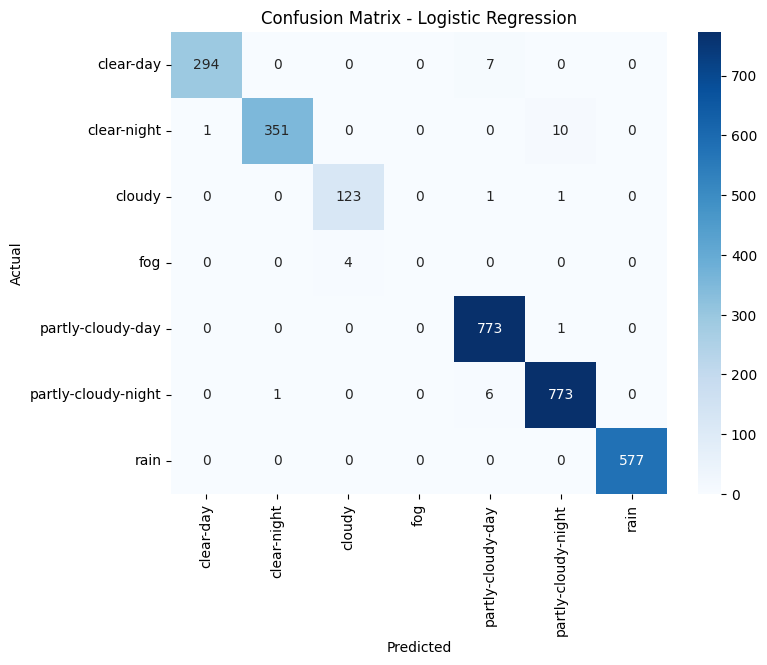

In [25]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [27]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9998
clear-night : 1.0000
cloudy   : 0.9976
fog      : 0.9928
partly-cloudy-day : 0.9995
partly-cloudy-night : 0.9997
rain     : 1.0000
Micro-avg : 0.9997


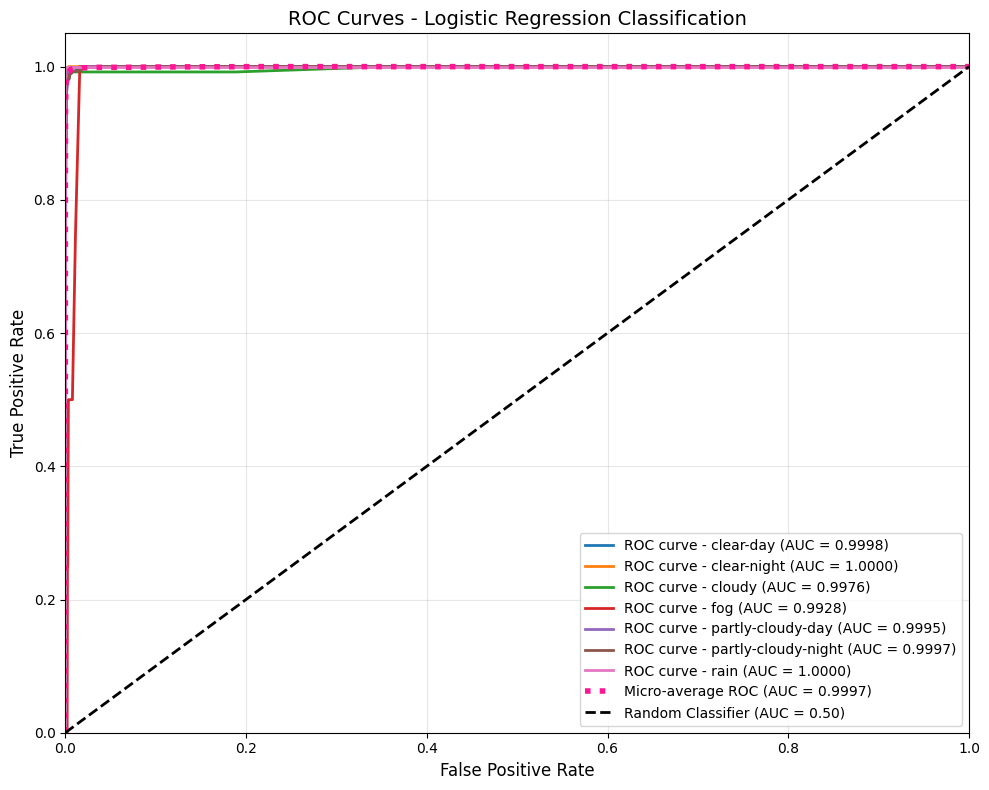

In [29]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9997
One-vs-One (Weighted)  : 0.9982
Micro-average          : 0.9997


In [31]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.989052, F1: 0.988365, AUC (micro-avg): 0.999728
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [32]:
grid_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [33]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
CPU times: user 58.9 s, sys: 11.4 s, total: 1min 10s
Wall time: 1h 44min 54s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [34]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_features': None, 'max_depth': 10, 'bootstrap': False}
Best Cross-Validation Score: 0.9931802413885855


In [35]:
y_pred_grid = best_grid_model.predict(X_test)

In [36]:
y_pred_grid

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [37]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [38]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [39]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9911
Precision: 0.9912
Recall:    0.9911
F1-Score:  0.9911


In [40]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      1.00      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.95      0.98      0.96       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      0.99      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



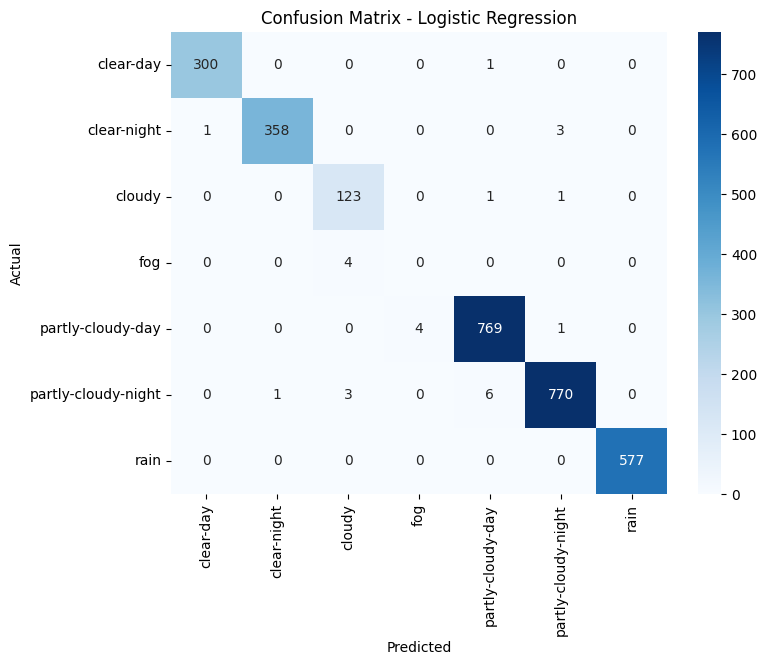

In [41]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [43]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [44]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9981
clear-night : 0.9964
cloudy   : 0.9912
fog      : 0.3695
partly-cloudy-day : 0.9981
partly-cloudy-night : 0.9977
rain     : 1.0000
Micro-avg : 0.9972


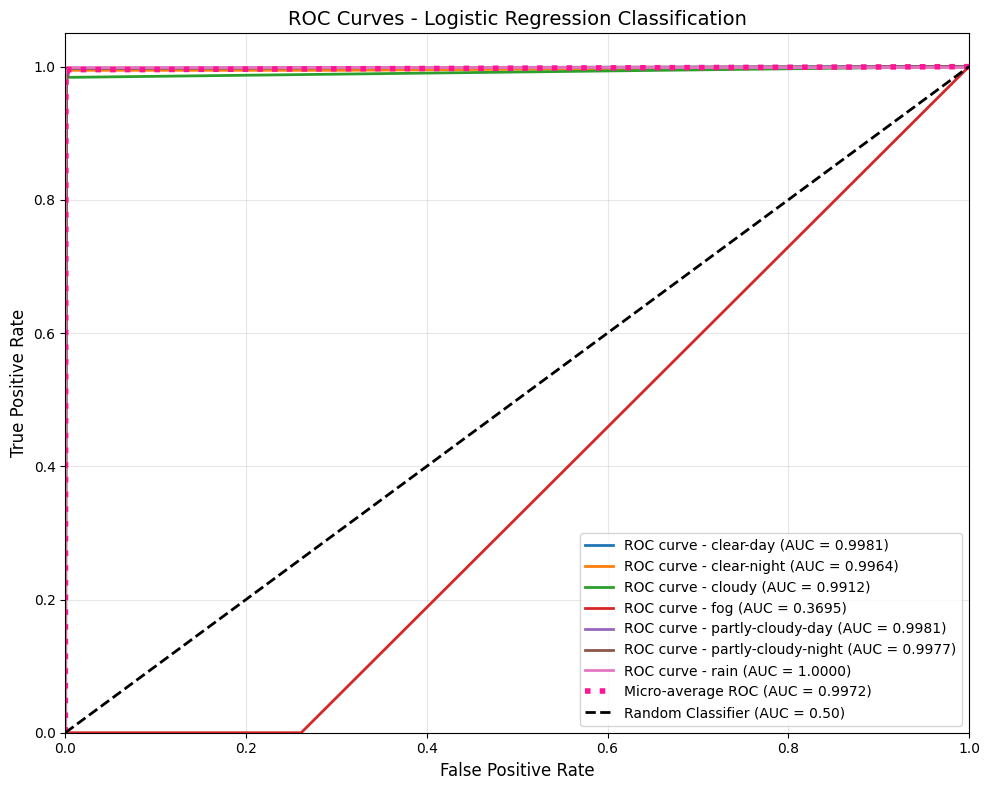

In [45]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9970
One-vs-One (Weighted)  : 0.9429
Micro-average          : 0.9972


In [47]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.991105, F1: 0.991128, AUC (micro-avg): 0.997248
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [48]:
base_model = RandomForestClassifier(random_state=42)
base_model

RandomForestClassifier(random_state=42)

In [49]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [50]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.1min remaining:  1.1min


CPU times: user 4.04 s, sys: 11.4 s, total: 15.4 s
Wall time: 1min 10s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [51]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.3s remaining:   11.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   20.2s finished


In [52]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [53]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9873
Precision: 0.9861
Recall:    0.9873
F1-Score:  0.9866


In [54]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       1.00      0.96      0.98       362
             cloudy       0.97      0.97      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.98      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.84      0.84      2923
       weighted avg       0.99      0.99      0.99      2923



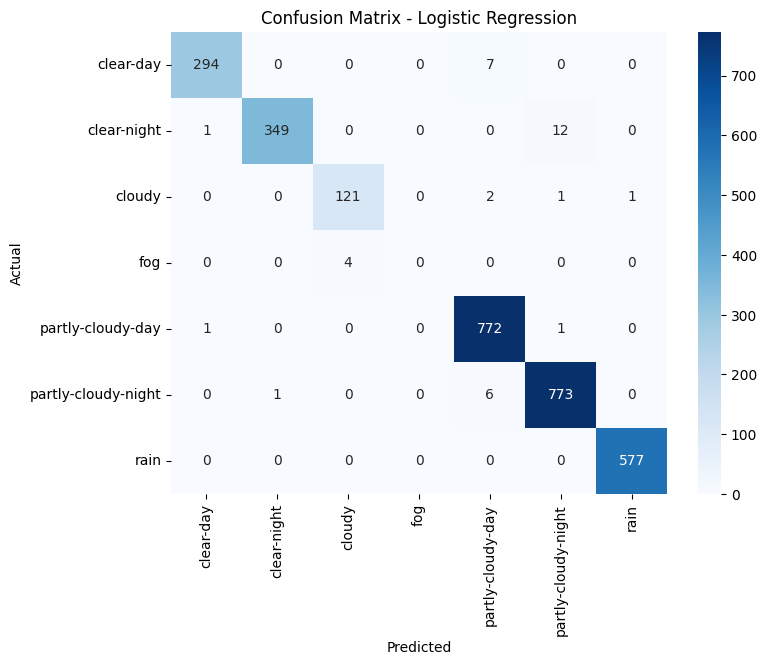

In [55]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.8s remaining:    7.8s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   13.6s finished


In [57]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [58]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9995
clear-night : 0.9999
cloudy   : 0.9962
fog      : 0.9953
partly-cloudy-day : 0.9995
partly-cloudy-night : 0.9995
rain     : 1.0000
Micro-avg : 0.9994


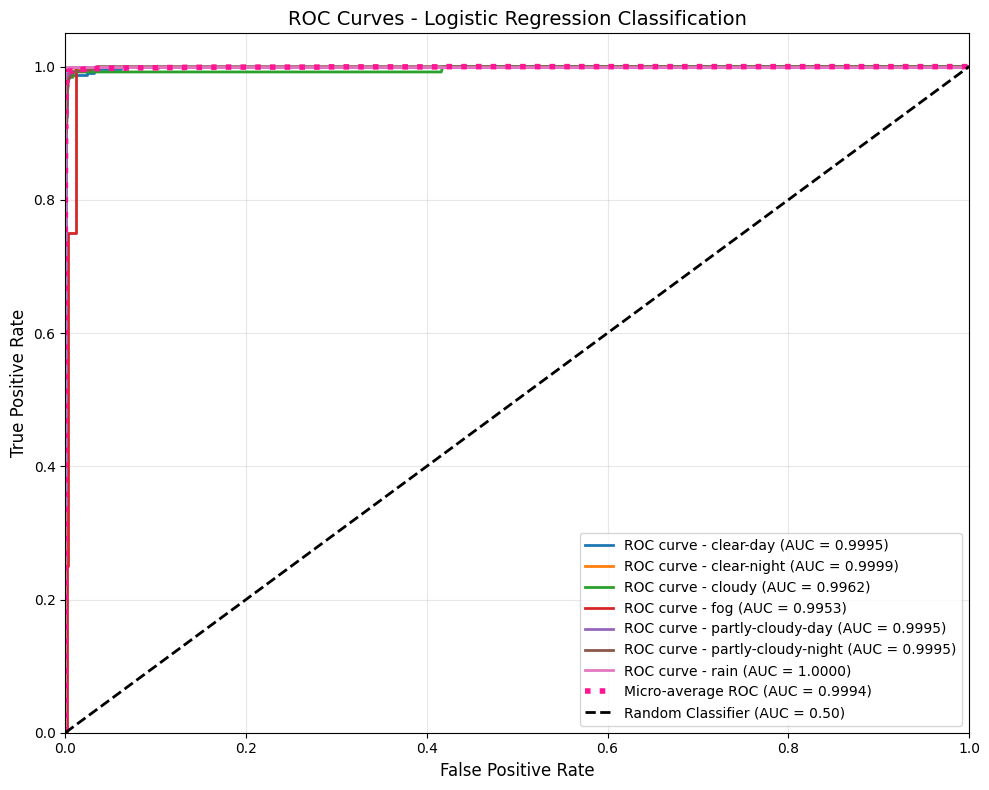

In [59]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [60]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9995
One-vs-One (Weighted)  : 0.9977
Micro-average          : 0.9994


In [61]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.987342, F1: 0.986645, AUC (micro-avg): 0.999365
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Standard Scaler

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [63]:
X_train

array([[ 0.08873237, -0.9946814 , -1.51753864, ..., -0.14489532,
        -0.73058589,  0.85292311],
       [ 0.08873237,  1.04440482,  1.07523376, ...,  0.50907697,
        -0.73058589, -0.4299225 ],
       [ 0.71351944,  1.38425252,  1.21927667, ..., -0.0533392 ,
        -0.73058589, -0.25690934],
       ...,
       [ 0.40112591,  0.59127454, -1.22945281, ...,  1.02116571,
        -0.73058589, -0.4299225 ],
       [ 0.08873237, -0.54155113, -0.07710953, ...,  0.95690582,
         2.19882202,  0.86767617],
       [ 0.40112591, -1.33452911, -0.36519535, ...,  1.29498106,
         0.80247092, -0.4299225 ]])

In [64]:
X_test

array([[ 1.33830651,  1.72410022, -1.51753864, ..., -1.4289557 ,
        -0.73058589, -0.4299225 ],
       [-0.22366116, -0.54155113, -1.22945281, ..., -0.12186412,
        -0.73058589, -0.49027592],
       [ 0.71351944,  0.47799198,  0.49906212, ...,  0.88667489,
         0.86431397,  0.7382516 ],
       ...,
       [ 0.71351944, -1.22124654, -1.22945281, ...,  0.10105513,
        -0.73058589, -0.4299225 ],
       [ 1.65070004, -0.314986  ,  0.35501921, ..., -0.69536939,
         1.54784248, -0.4299225 ],
       [ 0.71351944, -0.88139884, -0.07710953, ...,  1.32256164,
        -0.34325307, -0.4299225 ]])

### Default Parameters

In [65]:
training_model = RandomForestClassifier(random_state=42, verbose=1)
training_model

RandomForestClassifier(random_state=42, verbose=1)

In [66]:
%%time
training_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


RandomForestClassifier(random_state=42, verbose=1)

In [67]:
y_pred = training_model.predict(X_test)
y_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [68]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [69]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [70]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9891
Precision: 0.9878
Recall:    0.9891
F1-Score:  0.9884


In [71]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.98      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



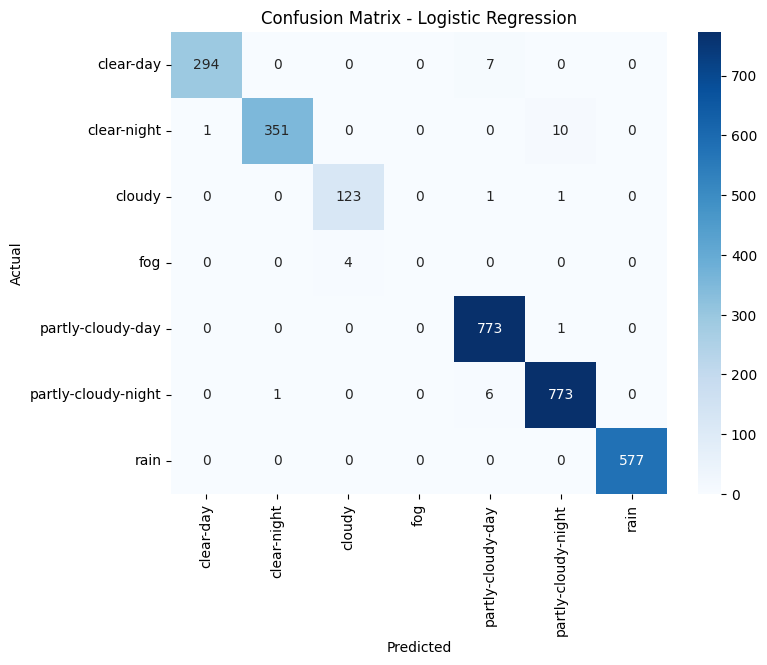

In [72]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [73]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [74]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [75]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9998
clear-night : 1.0000
cloudy   : 0.9976
fog      : 0.9928
partly-cloudy-day : 0.9995
partly-cloudy-night : 0.9997
rain     : 1.0000
Micro-avg : 0.9997


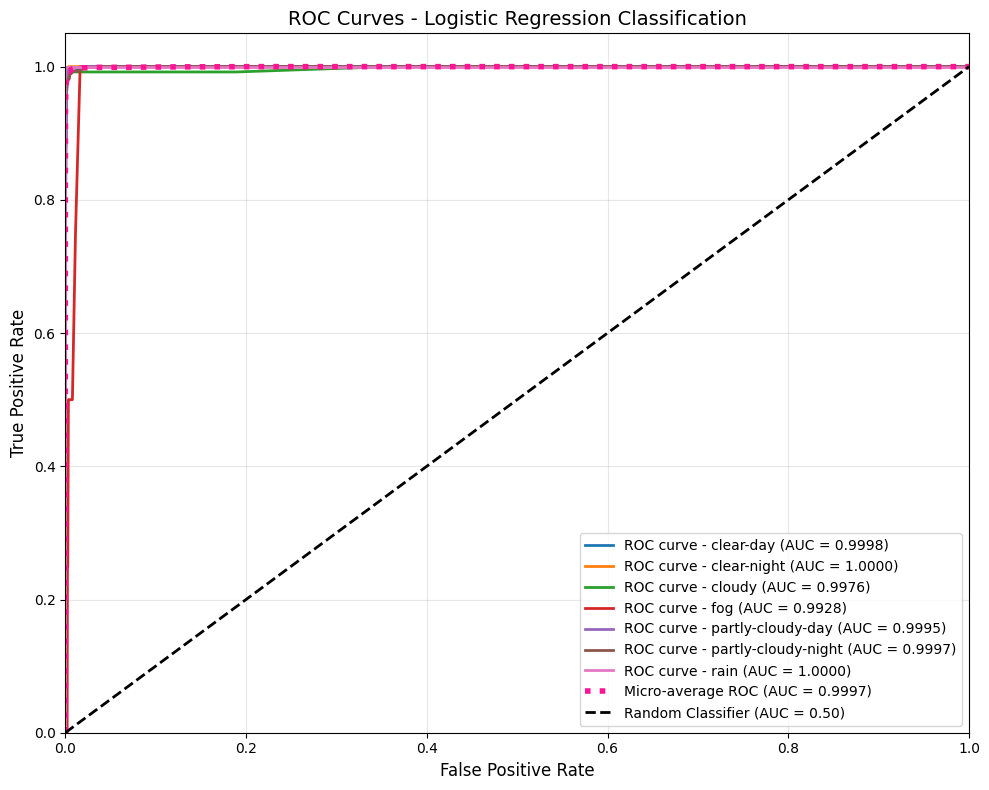

In [76]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9997
One-vs-One (Weighted)  : 0.9982
Micro-average          : 0.9997


In [78]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.989052, F1: 0.988365, AUC (micro-avg): 0.999729
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [79]:
grid_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [80]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
CPU times: user 1min, sys: 11.9 s, total: 1min 12s
Wall time: 1h 46min 46s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [81]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_features': None, 'max_depth': 10, 'bootstrap': False}
Best Cross-Validation Score: 0.9931802413885855


In [82]:
y_pred_grid = best_grid_model.predict(X_test)

In [83]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [84]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9911
Precision: 0.9912
Recall:    0.9911
F1-Score:  0.9911


In [85]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      1.00      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.95      0.98      0.96       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      0.99      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



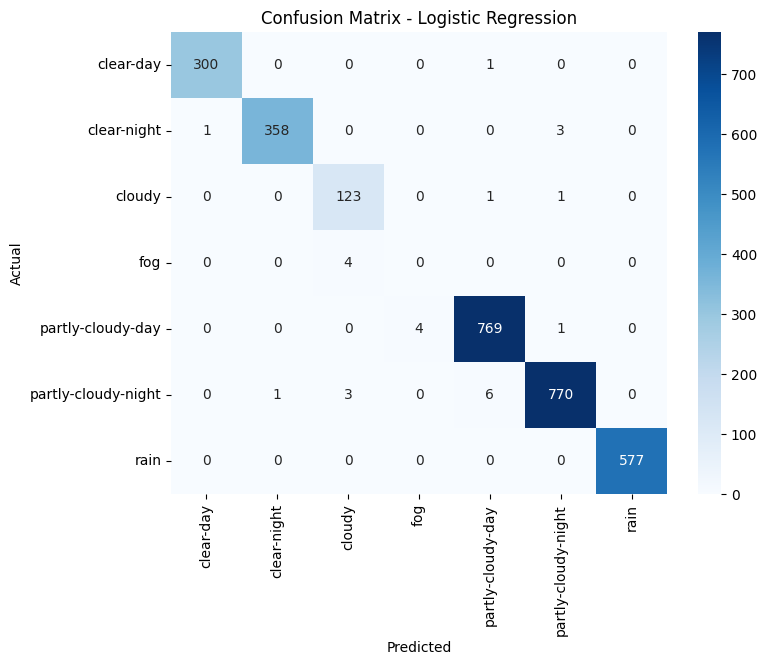

In [86]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [88]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [89]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9981
clear-night : 0.9964
cloudy   : 0.9912
fog      : 0.3695
partly-cloudy-day : 0.9981
partly-cloudy-night : 0.9977
rain     : 1.0000
Micro-avg : 0.9972


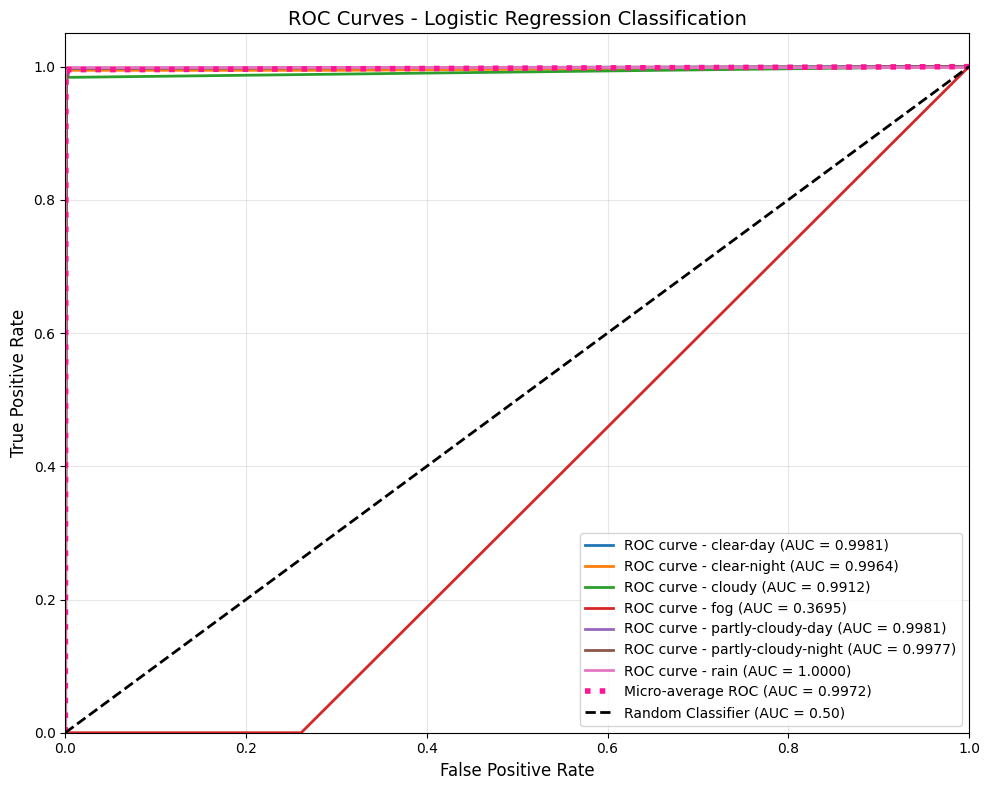

In [90]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [91]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9970
One-vs-One (Weighted)  : 0.9429
Micro-average          : 0.9972


In [92]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.991105, F1: 0.991128, AUC (micro-avg): 0.997248
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [93]:
base_model = RandomForestClassifier(random_state=42)
base_model

RandomForestClassifier(random_state=42)

In [94]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [95]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   59.2s remaining:   59.2s


CPU times: user 5.92 s, sys: 5.37 s, total: 11.3 s
Wall time: 1min 4s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [96]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.8s remaining:    7.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   13.1s finished


In [97]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [98]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9873
Precision: 0.9861
Recall:    0.9873
F1-Score:  0.9866


In [99]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       1.00      0.96      0.98       362
             cloudy       0.97      0.97      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.98      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.84      0.84      2923
       weighted avg       0.99      0.99      0.99      2923



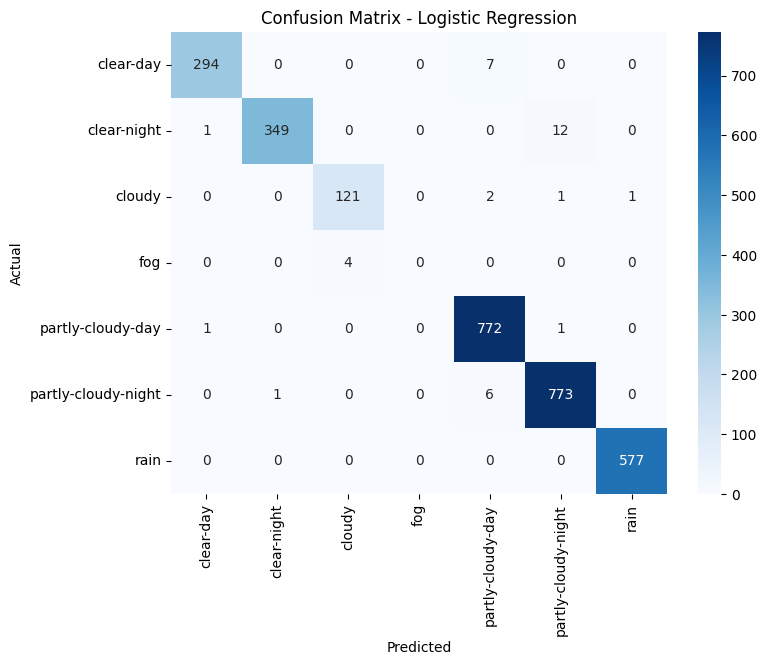

In [100]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [101]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   18.1s remaining:   18.1s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.5s finished


In [102]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [103]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9995
clear-night : 0.9999
cloudy   : 0.9962
fog      : 0.9953
partly-cloudy-day : 0.9995
partly-cloudy-night : 0.9995
rain     : 1.0000
Micro-avg : 0.9994


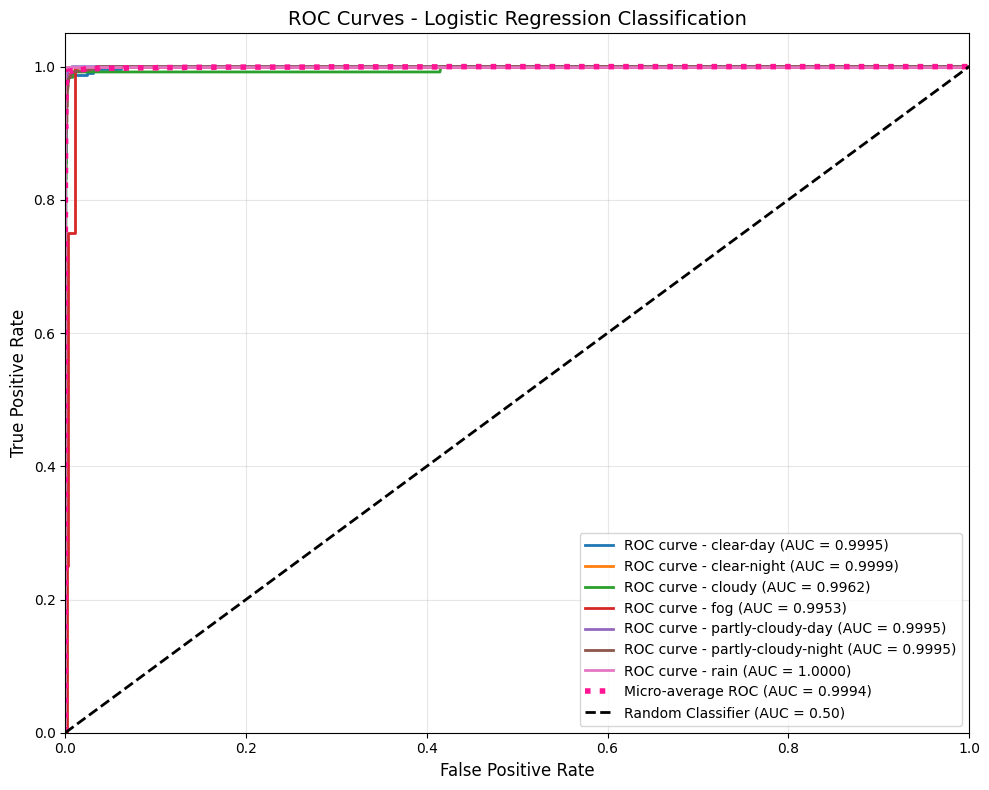

In [104]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [105]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9995
One-vs-One (Weighted)  : 0.9977
Micro-average          : 0.9994


In [106]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.987342, F1: 0.986645, AUC (micro-avg): 0.999367
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Robust Scaler

In [107]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [108]:
X_train

array([[ 0.00000000e+00, -6.00000000e-01, -9.16666667e-01, ...,
        -5.05562827e-02,  0.00000000e+00,  9.07710558e+00],
       [ 0.00000000e+00,  6.00000000e-01,  5.83333333e-01, ...,
         3.25752618e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  8.00000000e-01,  6.66666667e-01, ...,
         2.12696335e-03,  0.00000000e+00,  1.22419929e+00],
       ...,
       [ 2.00000000e-01,  3.33333333e-01, -7.50000000e-01, ...,
         6.20418848e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.33333333e-01, -8.33333333e-02, ...,
         5.83442408e-01,  1.94805195e+00,  9.18149466e+00],
       [ 2.00000000e-01, -8.00000000e-01, -2.50000000e-01, ...,
         7.77977749e-01,  1.01948052e+00,  0.00000000e+00]])

In [109]:
X_test

array([[ 0.8       ,  1.        , -0.91666667, ..., -0.78943063,
         0.        ,  0.        ],
       [-0.2       , -0.33333333, -0.75      , ..., -0.03730366,
         0.        , -0.42704626],
       [ 0.4       ,  0.26666667,  0.25      , ...,  0.5430301 ,
         1.06060606,  8.26571767],
       ...,
       [ 0.4       , -0.73333333, -0.75      , ...,  0.09096859,
         0.        ,  0.        ],
       [ 1.        , -0.2       ,  0.16666667, ..., -0.36731021,
         1.51515152,  0.        ],
       [ 0.4       , -0.53333333, -0.08333333, ...,  0.79384817,
         0.25757576,  0.        ]])

### Default Parameters

In [110]:
training_model = RandomForestClassifier(random_state=42, verbose=1)
training_model

RandomForestClassifier(random_state=42, verbose=1)

In [111]:
%%time
training_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


RandomForestClassifier(random_state=42, verbose=1)

In [112]:
y_pred = training_model.predict(X_test)
y_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [113]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [114]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [115]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9891
Precision: 0.9878
Recall:    0.9891
F1-Score:  0.9884


In [116]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.98      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



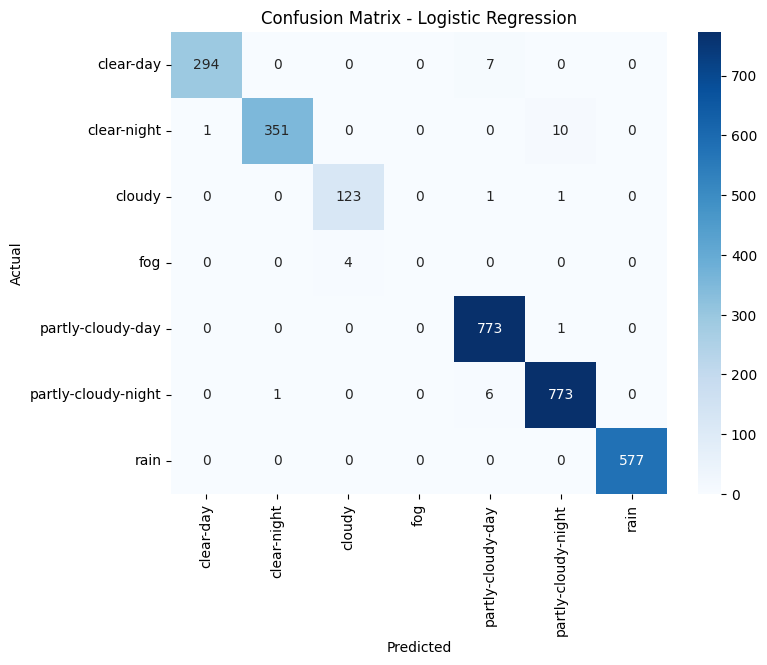

In [117]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [118]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [119]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [120]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9998
clear-night : 1.0000
cloudy   : 0.9976
fog      : 0.9927
partly-cloudy-day : 0.9995
partly-cloudy-night : 0.9997
rain     : 1.0000
Micro-avg : 0.9997


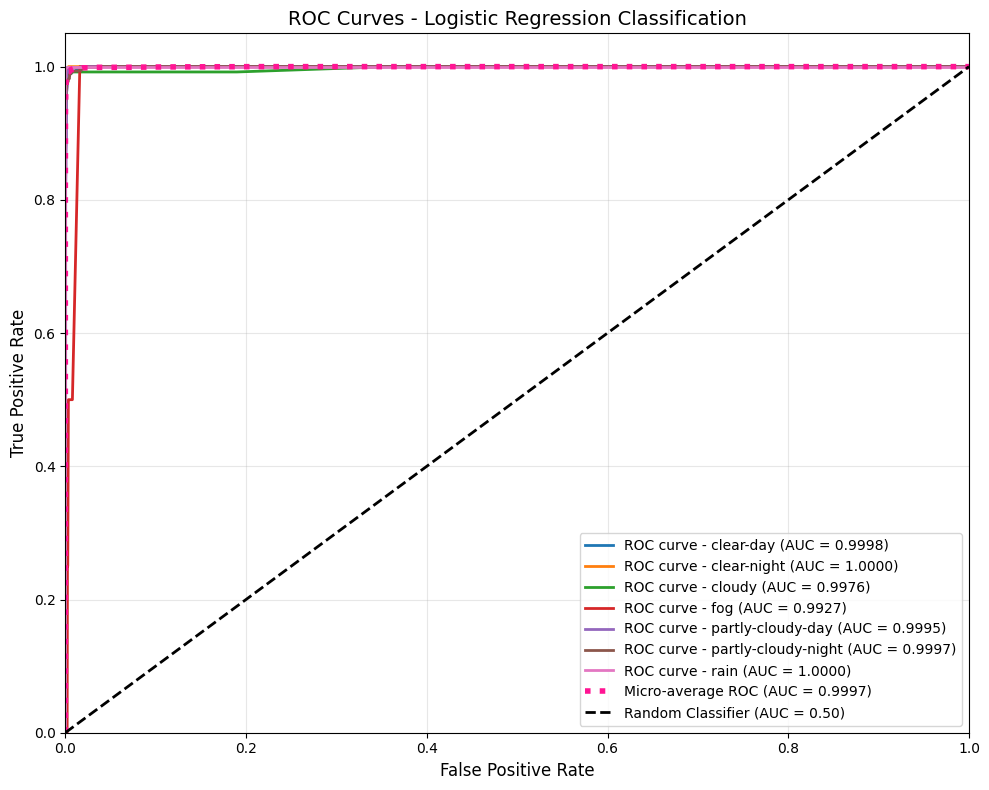

In [121]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [122]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9997
One-vs-One (Weighted)  : 0.9982
Micro-average          : 0.9997


In [123]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.989052, F1: 0.988365, AUC (micro-avg): 0.999729
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [124]:
grid_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [125]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
CPU times: user 59.4 s, sys: 11.7 s, total: 1min 11s
Wall time: 1h 45min 50s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [126]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_features': None, 'max_depth': 10, 'bootstrap': False}
Best Cross-Validation Score: 0.9931802413885855


In [127]:
y_pred_grid = best_grid_model.predict(X_test)

In [128]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [129]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9911
Precision: 0.9912
Recall:    0.9911
F1-Score:  0.9911


In [130]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      1.00      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.95      0.98      0.96       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      0.99      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



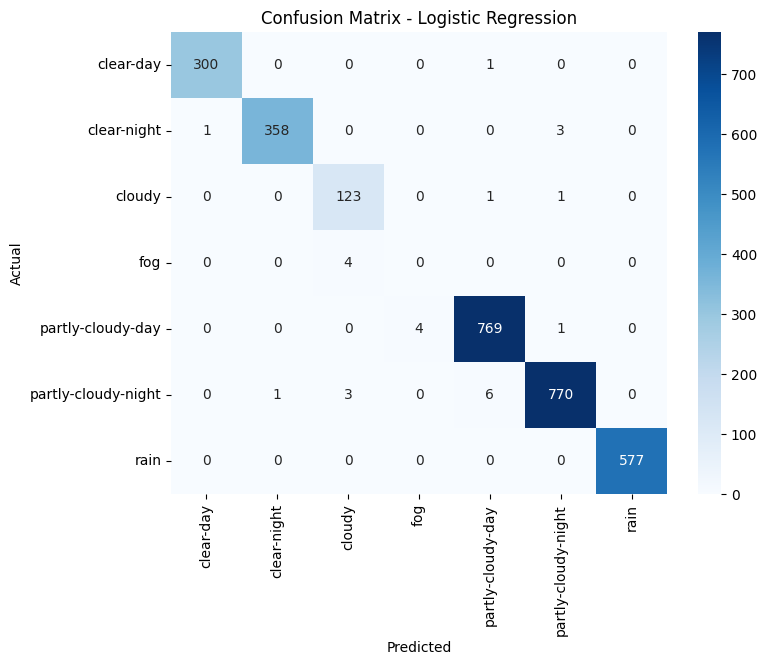

In [131]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [132]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [133]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [134]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9981
clear-night : 0.9964
cloudy   : 0.9912
fog      : 0.3695
partly-cloudy-day : 0.9981
partly-cloudy-night : 0.9977
rain     : 1.0000
Micro-avg : 0.9972


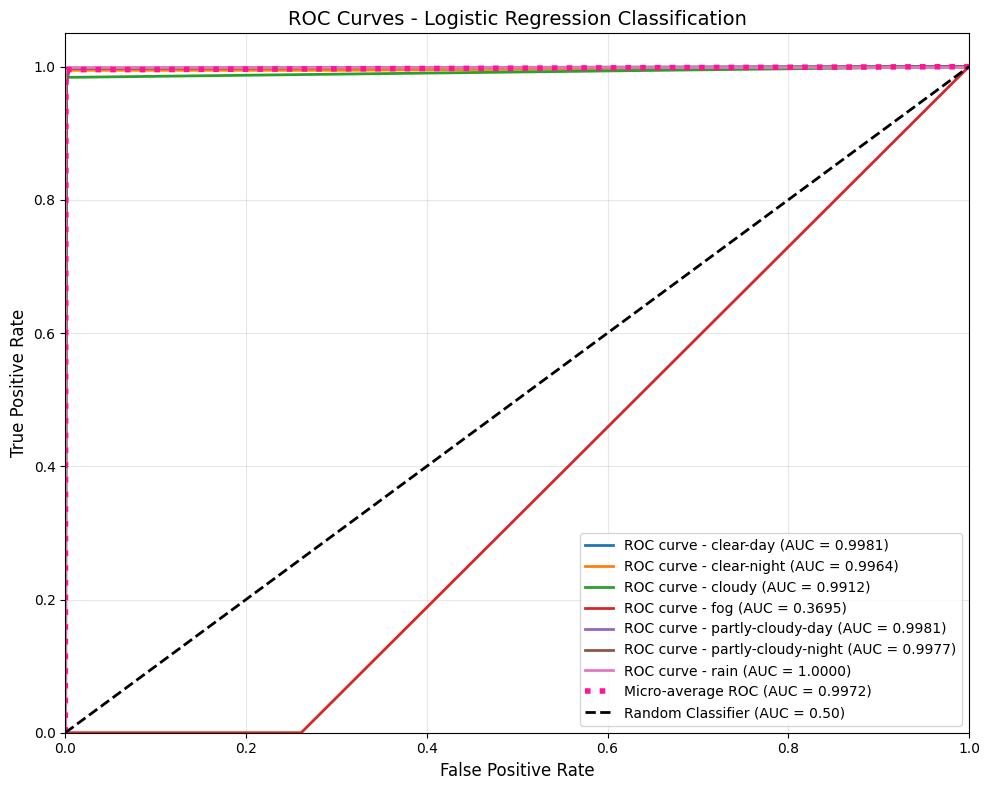

In [135]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [136]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9970
One-vs-One (Weighted)  : 0.9429
Micro-average          : 0.9972


In [137]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.991105, F1: 0.991128, AUC (micro-avg): 0.997248
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [138]:
base_model = RandomForestClassifier(random_state=42)
base_model

RandomForestClassifier(random_state=42)

In [139]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [140]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.1min remaining:  1.1min


CPU times: user 8.14 s, sys: 8.06 s, total: 16.2 s
Wall time: 1min 9s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [141]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.2s finished


In [142]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [143]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9873
Precision: 0.9861
Recall:    0.9873
F1-Score:  0.9866


In [144]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       1.00      0.96      0.98       362
             cloudy       0.97      0.97      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.98      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.84      0.84      2923
       weighted avg       0.99      0.99      0.99      2923



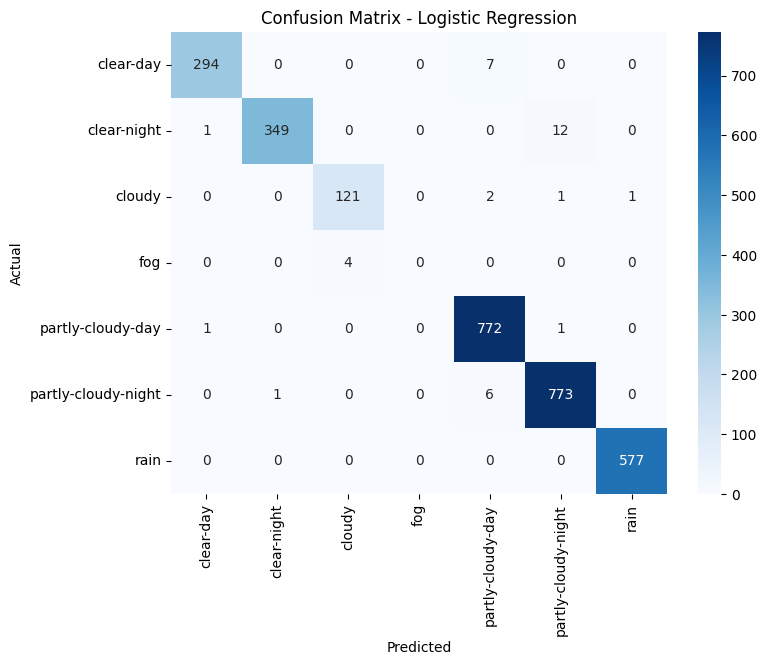

In [145]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [146]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.7s remaining:    6.7s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   11.7s finished


In [147]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [148]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9995
clear-night : 0.9999
cloudy   : 0.9962
fog      : 0.9952
partly-cloudy-day : 0.9995
partly-cloudy-night : 0.9995
rain     : 1.0000
Micro-avg : 0.9994


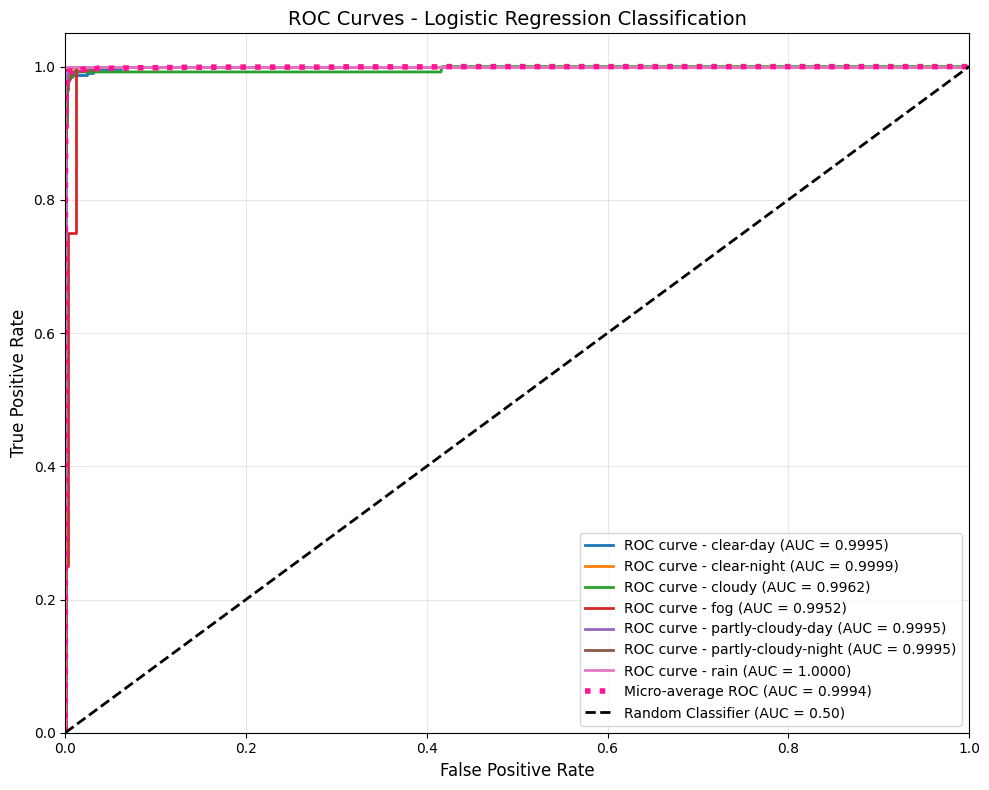

In [149]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [150]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9995
One-vs-One (Weighted)  : 0.9977
Micro-average          : 0.9994


In [151]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.987342, F1: 0.986645, AUC (micro-avg): 0.999363
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [152]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [153]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Icon']

In [154]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Icon']

In [155]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [156]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


### MinMax Scaler

In [157]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [158]:
X_train

array([[0.45454545, 0.04347826, 0.        , ..., 0.4839    , 0.        ,
        0.27580747],
       [0.45454545, 0.82608696, 0.        , ..., 0.7139    , 0.        ,
        0.07388643],
       [0.63636364, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.10111885],
       ...,
       [0.54545455, 0.13043478, 0.        , ..., 0.894     , 0.        ,
        0.07388643],
       [0.45454545, 0.47826087, 0.        , ..., 0.8714    , 0.9       ,
        0.27812962],
       [0.54545455, 0.39130435, 0.        , ..., 0.9903    , 0.471     ,
        0.07388643]])

In [159]:
X_test

array([[0.81818182, 0.04347826, 0.        , ..., 0.0323    , 0.        ,
        0.07388643],
       [0.36363636, 0.13043478, 0.        , ..., 0.492     , 0.        ,
        0.06438674],
       [0.63636364, 0.65217391, 1.        , ..., 0.8467    , 0.49      ,
        0.25775807],
       ...,
       [0.63636364, 0.13043478, 0.        , ..., 0.5704    , 0.        ,
        0.07388643],
       [0.90909091, 0.60869565, 1.        , ..., 0.2903    , 0.7       ,
        0.07388643],
       [0.63636364, 0.47826087, 0.        , ..., 1.        , 0.119     ,
        0.07388643]])

#### Default Parameters

In [160]:
training_model = RandomForestClassifier(random_state=42, verbose=1)
training_model

RandomForestClassifier(random_state=42, verbose=1)

In [161]:
%%time
training_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 1.41 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(random_state=42, verbose=1)

In [162]:
y_pred = training_model.predict(X_test)
y_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [163]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [164]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [165]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9901
Precision: 0.9888
Recall:    0.9901
F1-Score:  0.9894


In [166]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



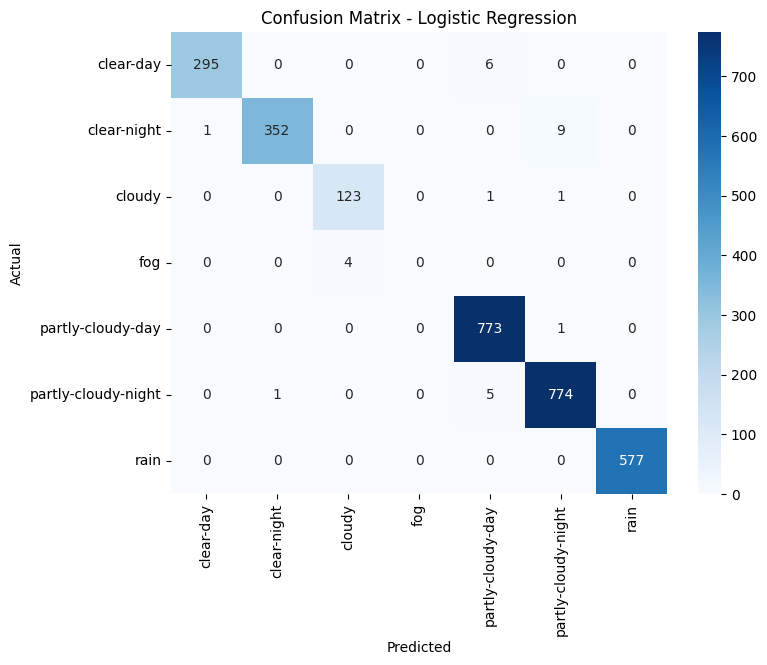

In [167]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [168]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [169]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [170]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9999
clear-night : 1.0000
cloudy   : 0.9976
fog      : 0.9937
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9998
rain     : 1.0000
Micro-avg : 0.9997


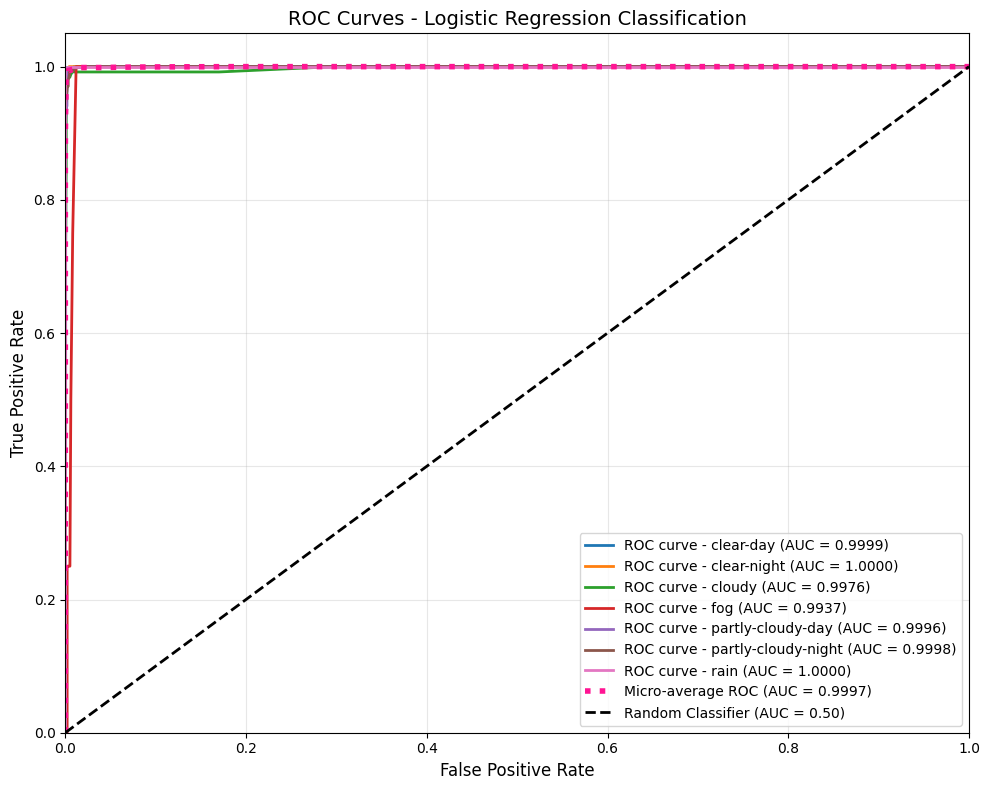

In [171]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [172]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9997
One-vs-One (Weighted)  : 0.9978
Micro-average          : 0.9997


In [173]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.989052 → 0.990079
   F1-Score: 0.988365 → 0.989394
   AUC (micro-avg): 0.999728 → 0.999748
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [174]:
grid_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [175]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
CPU times: user 30.7 s, sys: 8.78 s, total: 39.5 s
Wall time: 1h 19min 12s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [176]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_samples': 0.8, 'max_features': None, 'max_depth': None, 'bootstrap': True}
Best Cross-Validation Score: 0.993344012699793


In [177]:
y_pred_grid = best_grid_model.predict(X_test)

In [178]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [179]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9932
Precision: 0.9918
Recall:    0.9932
F1-Score:  0.9925


In [180]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      1.00      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



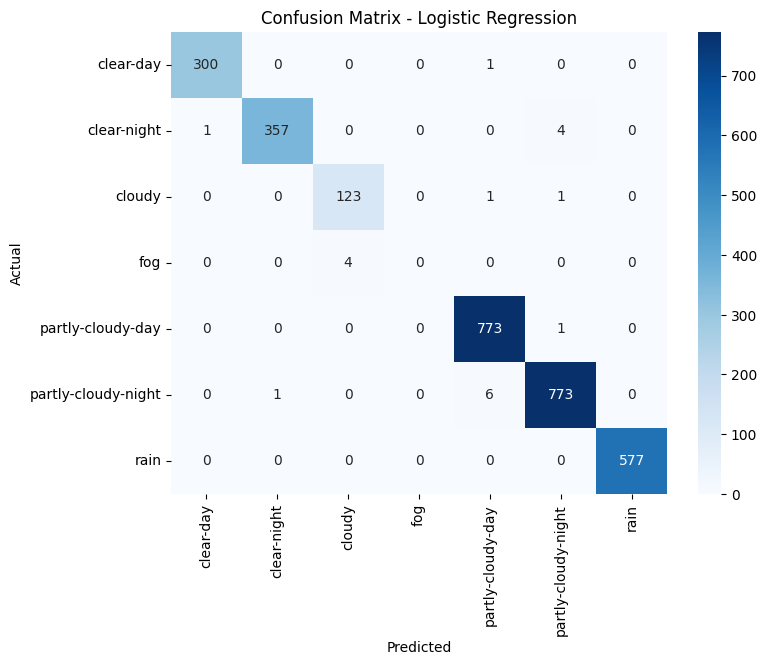

In [181]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [182]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [183]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [184]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 0.9986
cloudy   : 0.9912
fog      : 0.4949
partly-cloudy-day : 0.9991
partly-cloudy-night : 0.9992
rain     : 1.0000
Micro-avg : 0.9984


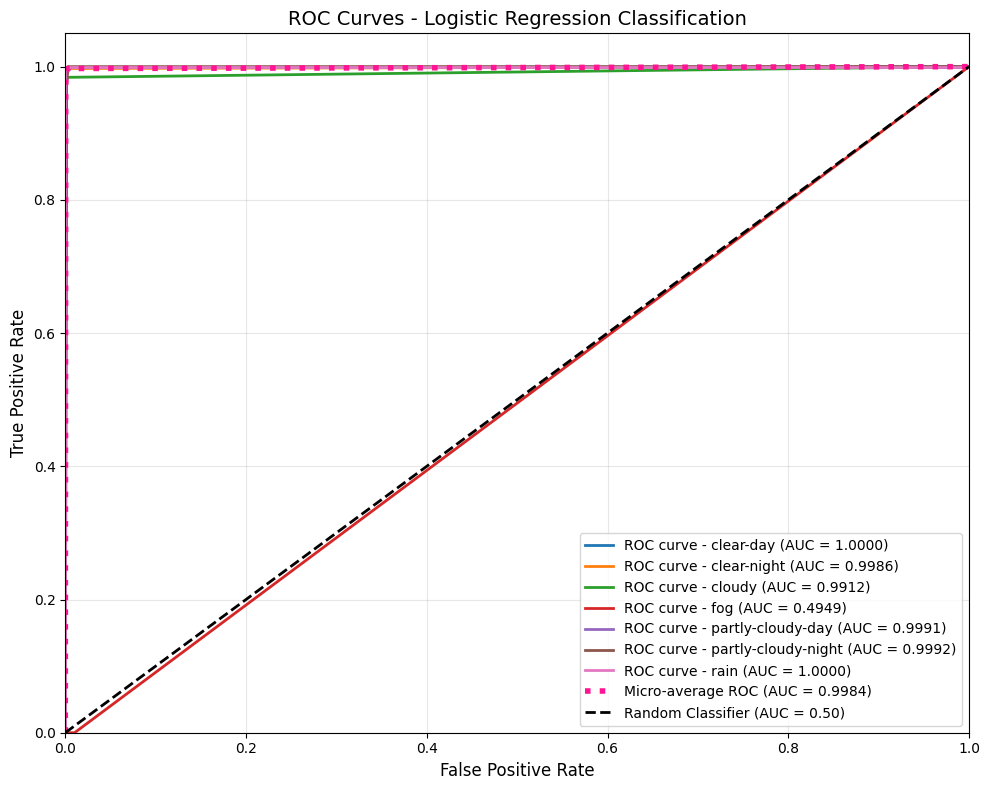

In [185]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [186]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9983
One-vs-One (Weighted)  : 0.9543
Micro-average          : 0.9984


In [187]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.991105 → 0.993158
   F1-Score: 0.991128 → 0.992481
   AUC (micro-avg): 0.997248 → 0.998370
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [188]:
base_model = RandomForestClassifier(random_state=42)
base_model

RandomForestClassifier(random_state=42)

In [189]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [190]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.1min remaining:  1.1min


CPU times: user 8.86 s, sys: 11.9 s, total: 20.8 s
Wall time: 1min 8s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [191]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.7s remaining:    9.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.4s finished


In [192]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [193]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9815
Precision: 0.9802
Recall:    0.9815
F1-Score:  0.9805


In [194]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.96      0.82      0.88       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.97      1.00      0.98       774
partly-cloudy-night       0.97      0.99      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.98      2923
          macro avg       0.84      0.82      0.83      2923
       weighted avg       0.98      0.98      0.98      2923



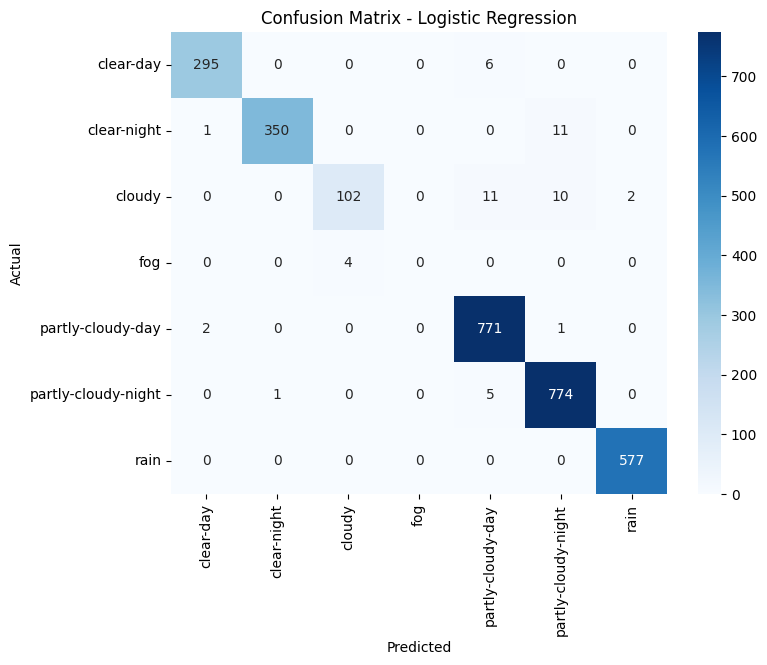

In [195]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [196]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.3s finished


In [197]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [198]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9988
clear-night : 0.9993
cloudy   : 0.9966
fog      : 0.9946
partly-cloudy-day : 0.9992
partly-cloudy-night : 0.9987
rain     : 1.0000
Micro-avg : 0.9991


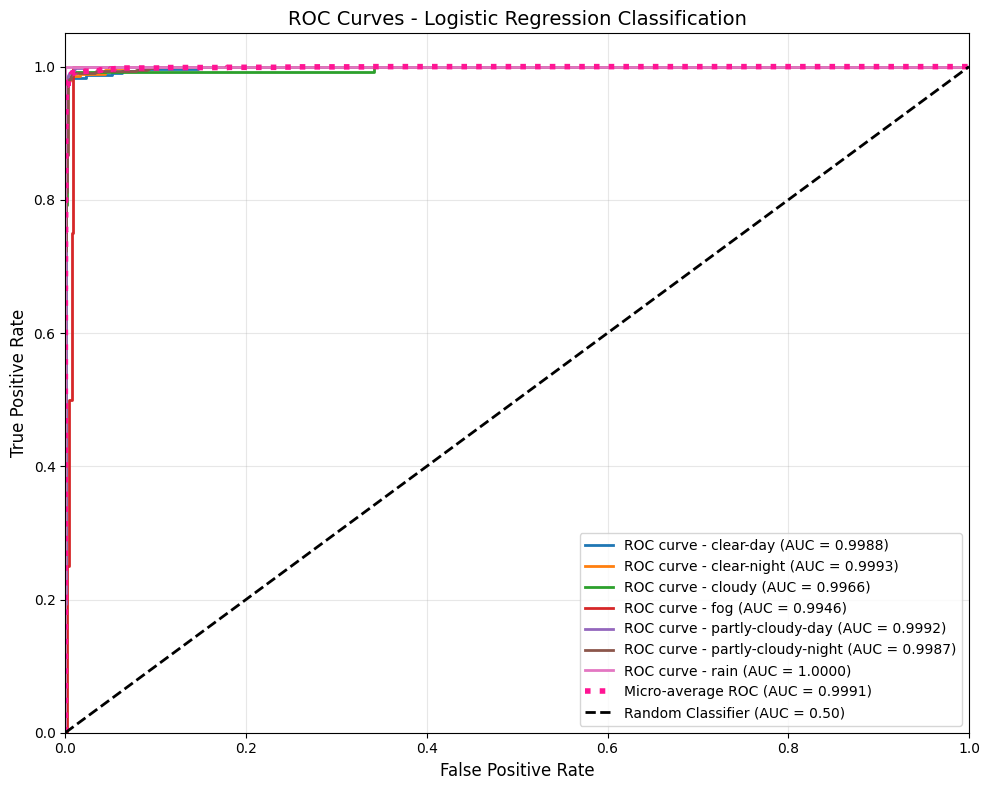

In [199]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [200]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9991
One-vs-One (Weighted)  : 0.9968
Micro-average          : 0.9991


In [201]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.987342 ≈ 0.981526 (similar)
   F1-Score: 0.986645 ≈ 0.980521 (similar)
   AUC (micro-avg): 0.999365 ≈ 0.999053
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


### Standard Scaler

In [202]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [203]:
X_train

array([[ 0.08873237, -1.51753864, -0.3888967 , ..., -0.14489532,
        -0.73058589,  0.85292311],
       [ 0.08873237,  1.07523376, -0.3888967 , ...,  0.50907697,
        -0.73058589, -0.4299225 ],
       [ 0.71351944,  1.21927667, -0.3888967 , ..., -0.0533392 ,
        -0.73058589, -0.25690934],
       ...,
       [ 0.40112591, -1.22945281, -0.3888967 , ...,  1.02116571,
        -0.73058589, -0.4299225 ],
       [ 0.08873237, -0.07710953, -0.3888967 , ...,  0.95690582,
         2.19882202,  0.86767617],
       [ 0.40112591, -0.36519535, -0.3888967 , ...,  1.29498106,
         0.80247092, -0.4299225 ]])

In [204]:
X_test

array([[ 1.33830651, -1.51753864, -0.3888967 , ..., -1.4289557 ,
        -0.73058589, -0.4299225 ],
       [-0.22366116, -1.22945281, -0.3888967 , ..., -0.12186412,
        -0.73058589, -0.49027592],
       [ 0.71351944,  0.49906212,  2.5713769 , ...,  0.88667489,
         0.86431397,  0.7382516 ],
       ...,
       [ 0.71351944, -1.22945281, -0.3888967 , ...,  0.10105513,
        -0.73058589, -0.4299225 ],
       [ 1.65070004,  0.35501921,  2.5713769 , ..., -0.69536939,
         1.54784248, -0.4299225 ],
       [ 0.71351944, -0.07710953, -0.3888967 , ...,  1.32256164,
        -0.34325307, -0.4299225 ]])

#### Default Parameters

In [205]:
training_model = RandomForestClassifier(random_state=42, verbose=1)
training_model

RandomForestClassifier(random_state=42, verbose=1)

In [206]:
%%time
training_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 1.41 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(random_state=42, verbose=1)

In [207]:
y_pred = training_model.predict(X_test)
y_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [208]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [209]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [210]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9901
Precision: 0.9888
Recall:    0.9901
F1-Score:  0.9894


In [211]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



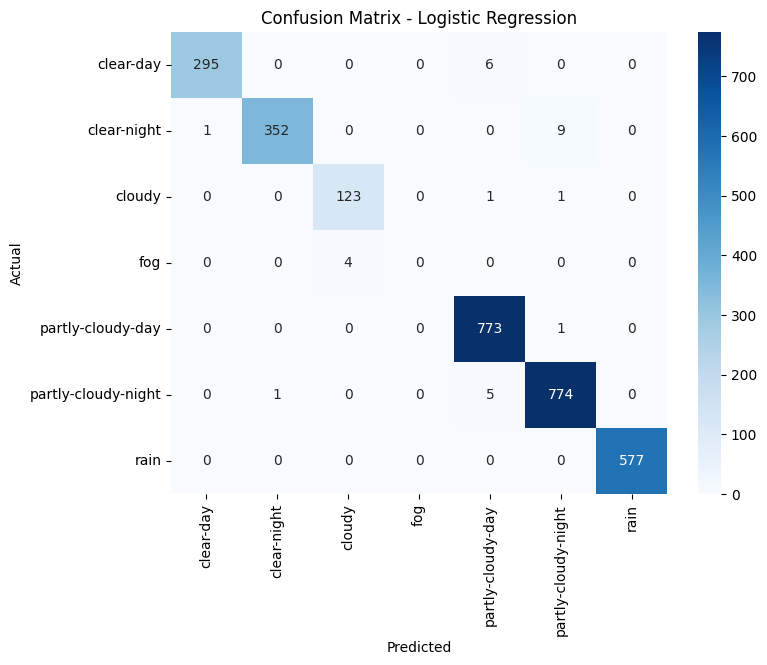

In [212]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [213]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [214]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [215]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9999
clear-night : 1.0000
cloudy   : 0.9976
fog      : 0.9937
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9998
rain     : 1.0000
Micro-avg : 0.9997


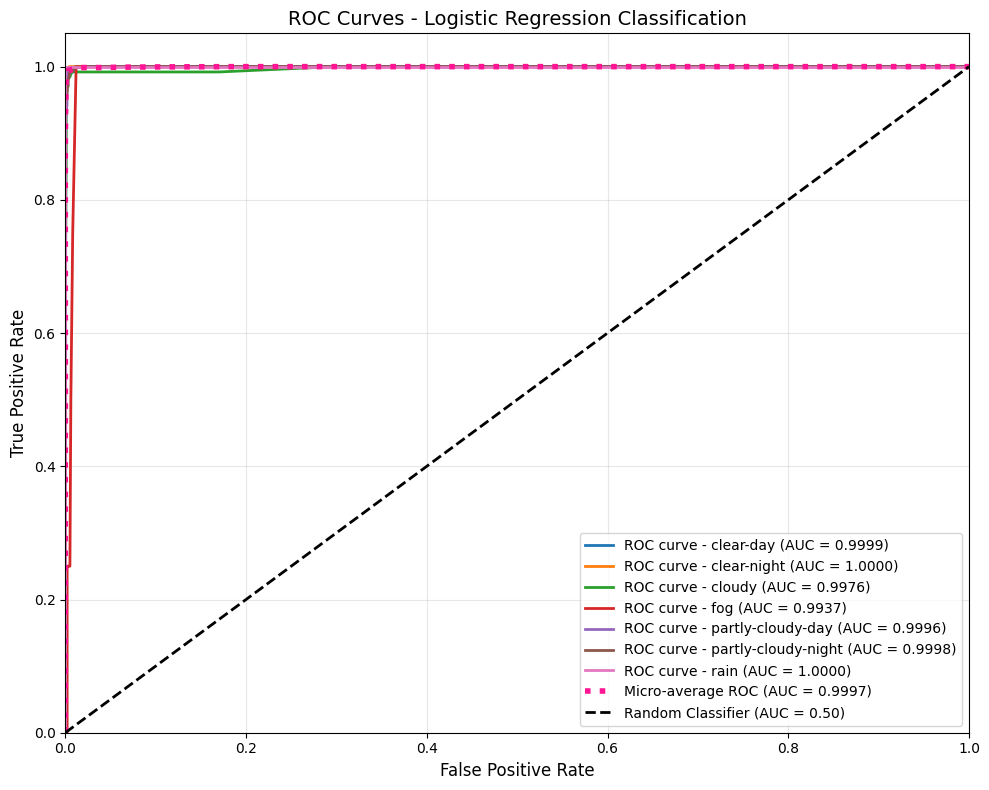

In [216]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [217]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9997
One-vs-One (Weighted)  : 0.9978
Micro-average          : 0.9997


In [218]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.989052 → 0.990079
   F1-Score: 0.988365 → 0.989394
   AUC (micro-avg): 0.999729 → 0.999748
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [219]:
grid_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [220]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
CPU times: user 30.5 s, sys: 8.87 s, total: 39.4 s
Wall time: 1h 19min 11s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [221]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_samples': 0.8, 'max_features': None, 'max_depth': None, 'bootstrap': True}
Best Cross-Validation Score: 0.993344012699793


In [222]:
y_pred_grid = best_grid_model.predict(X_test)

In [223]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [224]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9932
Precision: 0.9918
Recall:    0.9932
F1-Score:  0.9925


In [225]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      1.00      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



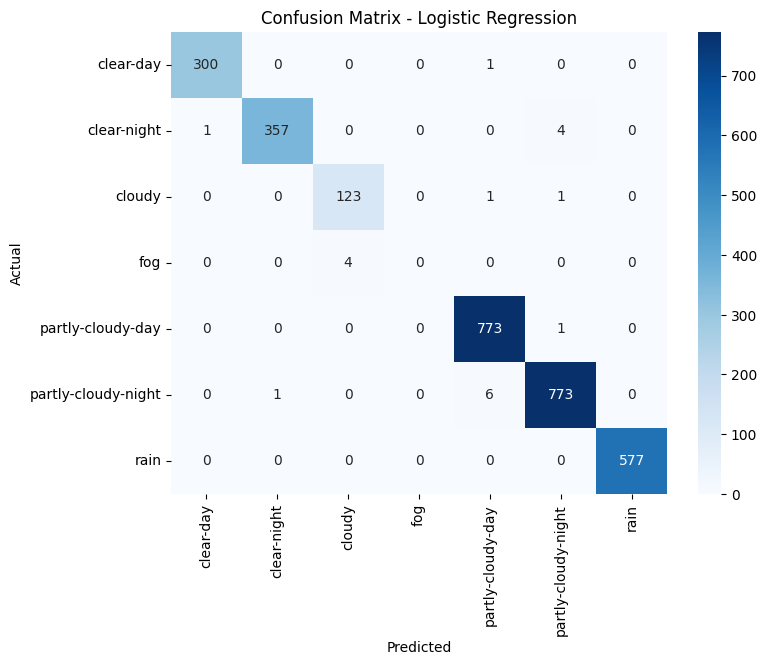

In [226]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [227]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [228]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [229]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 0.9986
cloudy   : 0.9912
fog      : 0.4949
partly-cloudy-day : 0.9991
partly-cloudy-night : 0.9992
rain     : 1.0000
Micro-avg : 0.9984


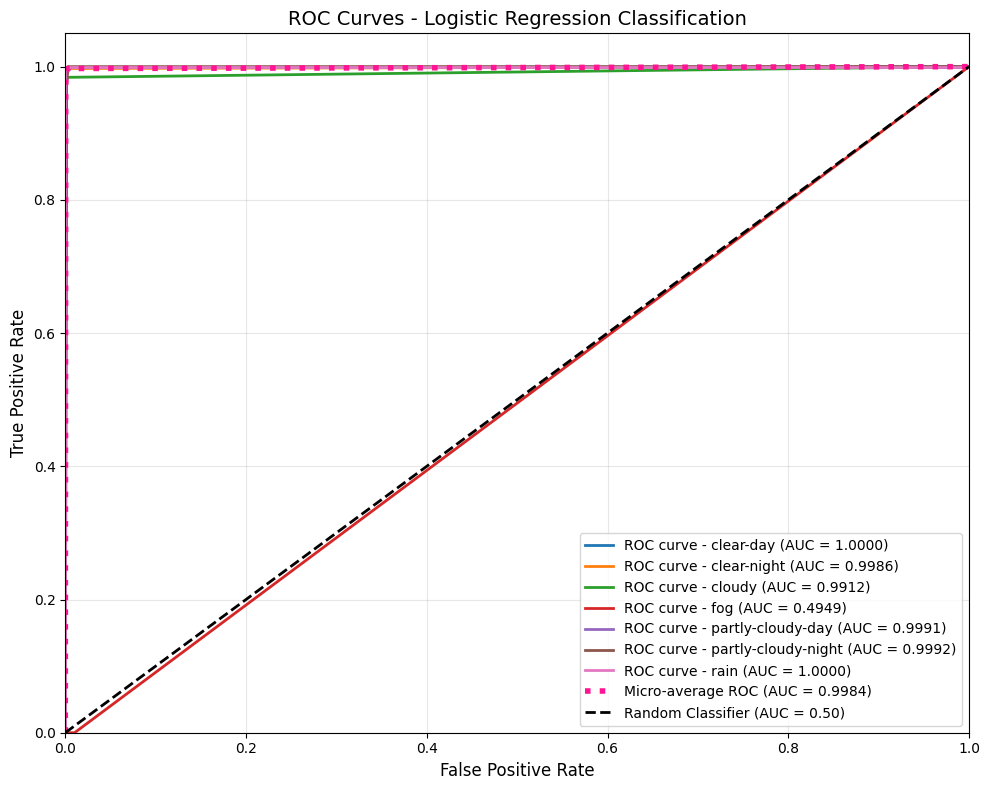

In [230]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [231]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9983
One-vs-One (Weighted)  : 0.9543
Micro-average          : 0.9984


In [232]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.991105 → 0.993158
   F1-Score: 0.991128 → 0.992481
   AUC (micro-avg): 0.997248 → 0.998370
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [233]:
base_model = RandomForestClassifier(random_state=42)
base_model

RandomForestClassifier(random_state=42)

In [234]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [235]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.0min remaining:  1.0min


CPU times: user 8.53 s, sys: 11.1 s, total: 19.6 s
Wall time: 1min 10s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [236]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.1s finished


In [237]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [238]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9815
Precision: 0.9802
Recall:    0.9815
F1-Score:  0.9805


In [239]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.96      0.82      0.88       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.97      1.00      0.98       774
partly-cloudy-night       0.97      0.99      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.98      2923
          macro avg       0.84      0.82      0.83      2923
       weighted avg       0.98      0.98      0.98      2923



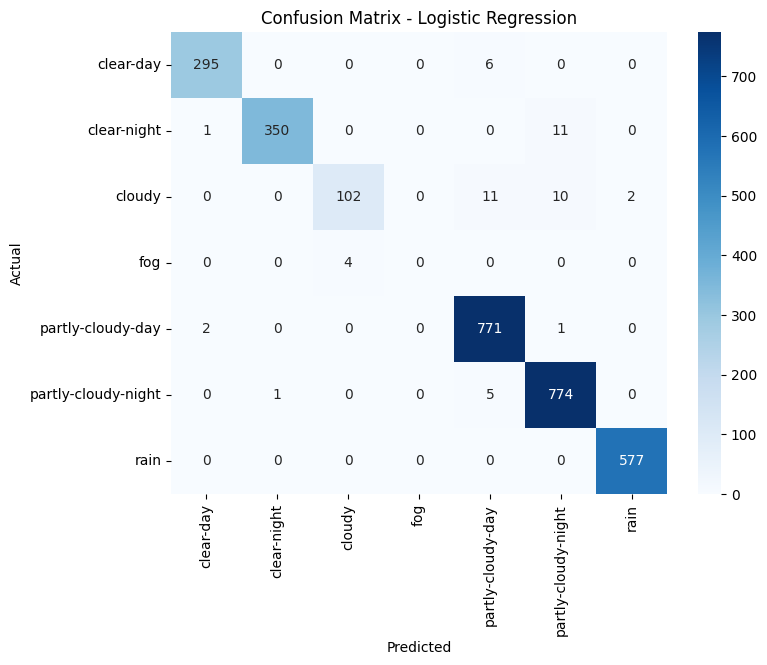

In [240]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [241]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.0s remaining:    8.0s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.4s finished


In [242]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [243]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9988
clear-night : 0.9993
cloudy   : 0.9966
fog      : 0.9948
partly-cloudy-day : 0.9992
partly-cloudy-night : 0.9987
rain     : 1.0000
Micro-avg : 0.9991


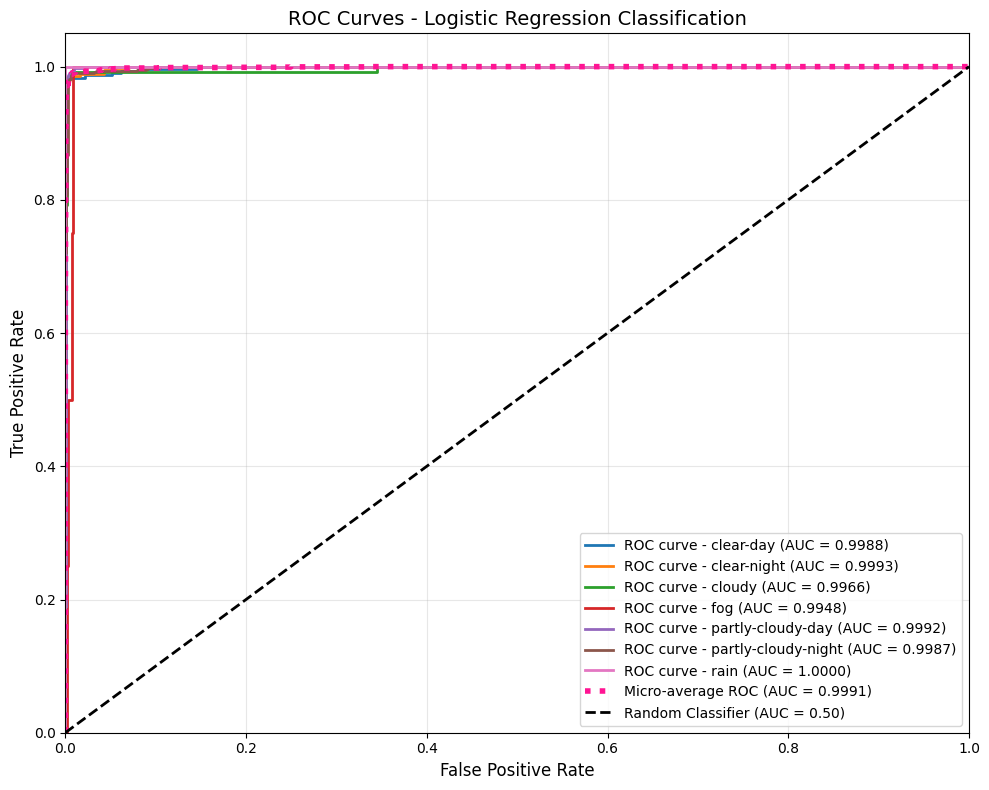

In [244]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [245]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9991
One-vs-One (Weighted)  : 0.9968
Micro-average          : 0.9991


In [246]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.987342 ≈ 0.981526 (similar)
   F1-Score: 0.986645 ≈ 0.980521 (similar)
   AUC (micro-avg): 0.999367 ≈ 0.999054
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


### Robust Scaler

In [247]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [248]:
X_train

array([[ 0.00000000e+00, -9.16666667e-01,  0.00000000e+00, ...,
        -5.05562827e-02,  0.00000000e+00,  9.07710558e+00],
       [ 0.00000000e+00,  5.83333333e-01,  0.00000000e+00, ...,
         3.25752618e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  6.66666667e-01,  0.00000000e+00, ...,
         2.12696335e-03,  0.00000000e+00,  1.22419929e+00],
       ...,
       [ 2.00000000e-01, -7.50000000e-01,  0.00000000e+00, ...,
         6.20418848e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.33333333e-02,  0.00000000e+00, ...,
         5.83442408e-01,  1.94805195e+00,  9.18149466e+00],
       [ 2.00000000e-01, -2.50000000e-01,  0.00000000e+00, ...,
         7.77977749e-01,  1.01948052e+00,  0.00000000e+00]])

In [249]:
X_test

array([[ 0.8       , -0.91666667,  0.        , ..., -0.78943063,
         0.        ,  0.        ],
       [-0.2       , -0.75      ,  0.        , ..., -0.03730366,
         0.        , -0.42704626],
       [ 0.4       ,  0.25      ,  1.        , ...,  0.5430301 ,
         1.06060606,  8.26571767],
       ...,
       [ 0.4       , -0.75      ,  0.        , ...,  0.09096859,
         0.        ,  0.        ],
       [ 1.        ,  0.16666667,  1.        , ..., -0.36731021,
         1.51515152,  0.        ],
       [ 0.4       , -0.08333333,  0.        , ...,  0.79384817,
         0.25757576,  0.        ]])

#### Default Parameters

In [250]:
training_model = RandomForestClassifier(random_state=42, verbose=1)
training_model

RandomForestClassifier(random_state=42, verbose=1)

In [251]:
%%time
training_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 1.41 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(random_state=42, verbose=1)

In [252]:
y_pred = training_model.predict(X_test)
y_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], dtype=object)

In [253]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [254]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [255]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9901
Precision: 0.9888
Recall:    0.9901
F1-Score:  0.9894


In [256]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



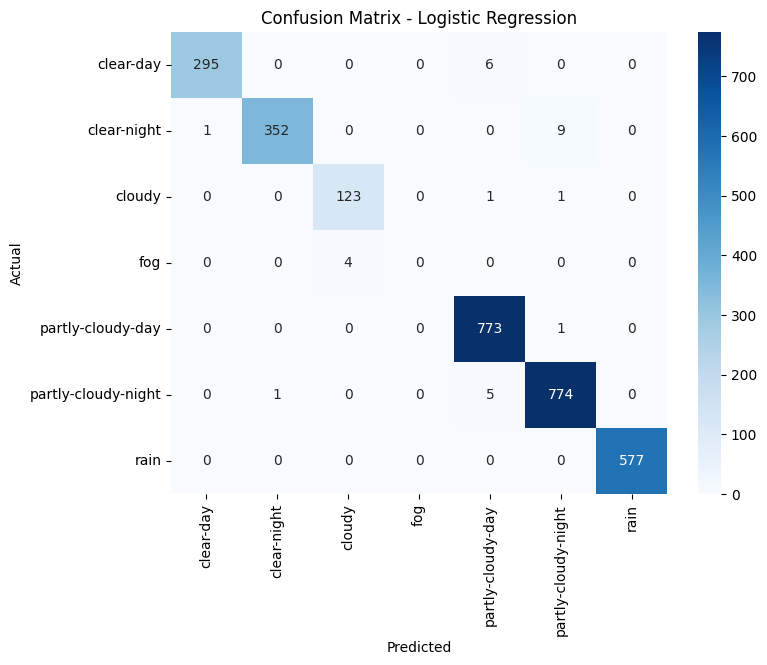

In [257]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [258]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [259]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [260]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9999
clear-night : 1.0000
cloudy   : 0.9976
fog      : 0.9937
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9998
rain     : 1.0000
Micro-avg : 0.9997


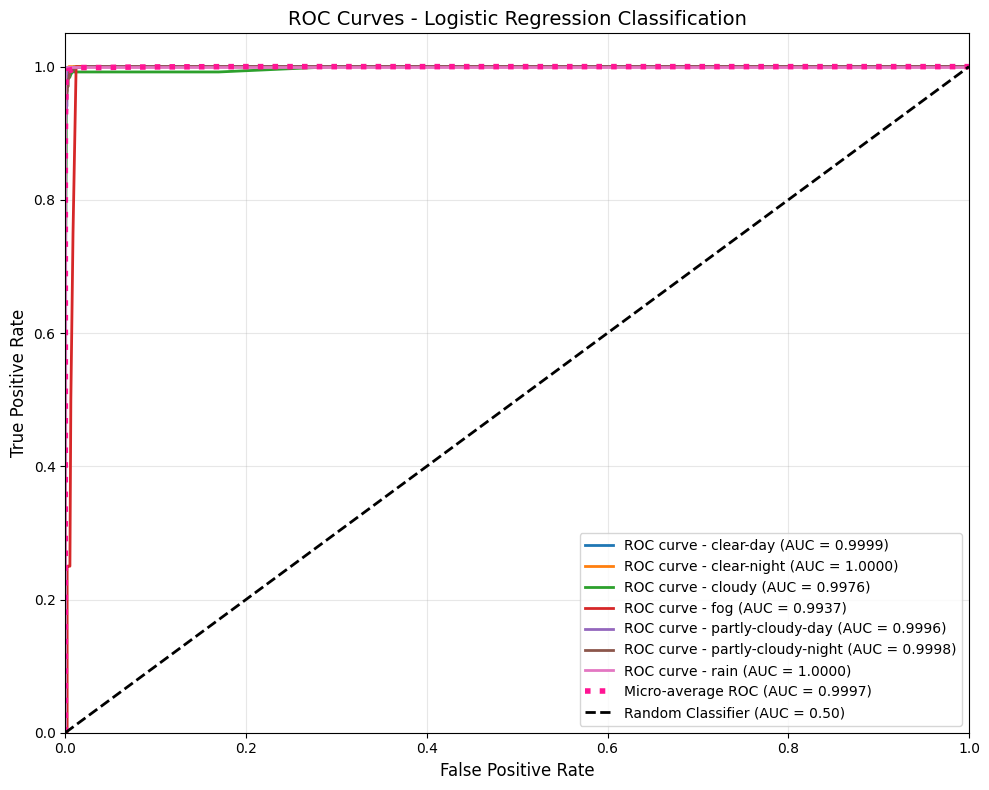

In [261]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [262]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9997
One-vs-One (Weighted)  : 0.9978
Micro-average          : 0.9997


In [263]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.989052 → 0.990079
   F1-Score: 0.988365 → 0.989394
   AUC (micro-avg): 0.999729 → 0.999748
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [264]:
grid_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [265]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
CPU times: user 29.6 s, sys: 9.11 s, total: 38.7 s
Wall time: 1h 18min 50s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=700, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'max_samples': [None, 0.8, 0.9],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]},
                                        {'bootstrap': [False],
                                         'max_depth': [None, 10, 20, 30],
                                         'max_features': ['sqrt', 'log2', None],
                                         'min_impurity_decrease': [0.0, 0.01,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 4, 6],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [266]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_samples': 0.8, 'max_features': None, 'max_depth': None, 'bootstrap': True}
Best Cross-Validation Score: 0.993344012699793


In [267]:
y_pred_grid = best_grid_model.predict(X_test)

In [268]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [269]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9932
Precision: 0.9918
Recall:    0.9932
F1-Score:  0.9925


In [270]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      1.00      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.97      0.98      0.98       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



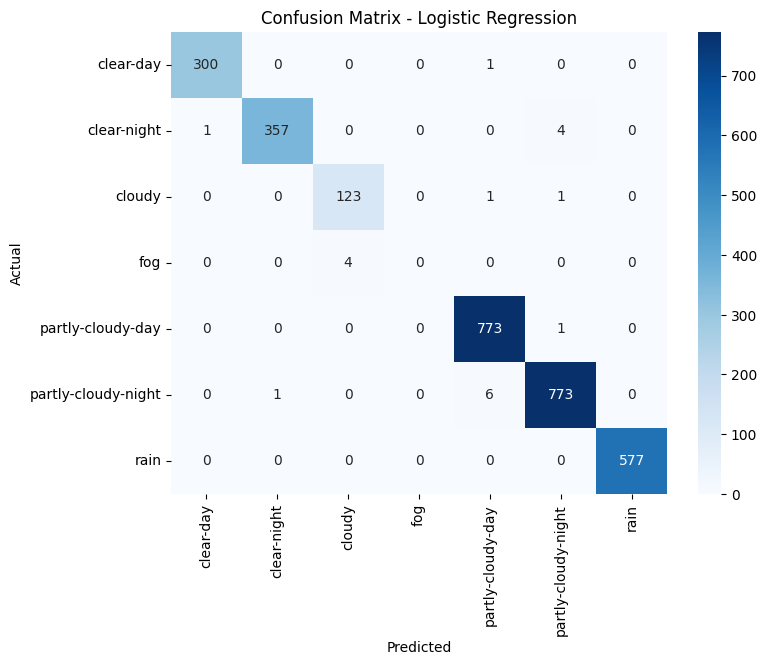

In [271]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [272]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [273]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [274]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 0.9986
cloudy   : 0.9912
fog      : 0.4949
partly-cloudy-day : 0.9991
partly-cloudy-night : 0.9992
rain     : 1.0000
Micro-avg : 0.9984


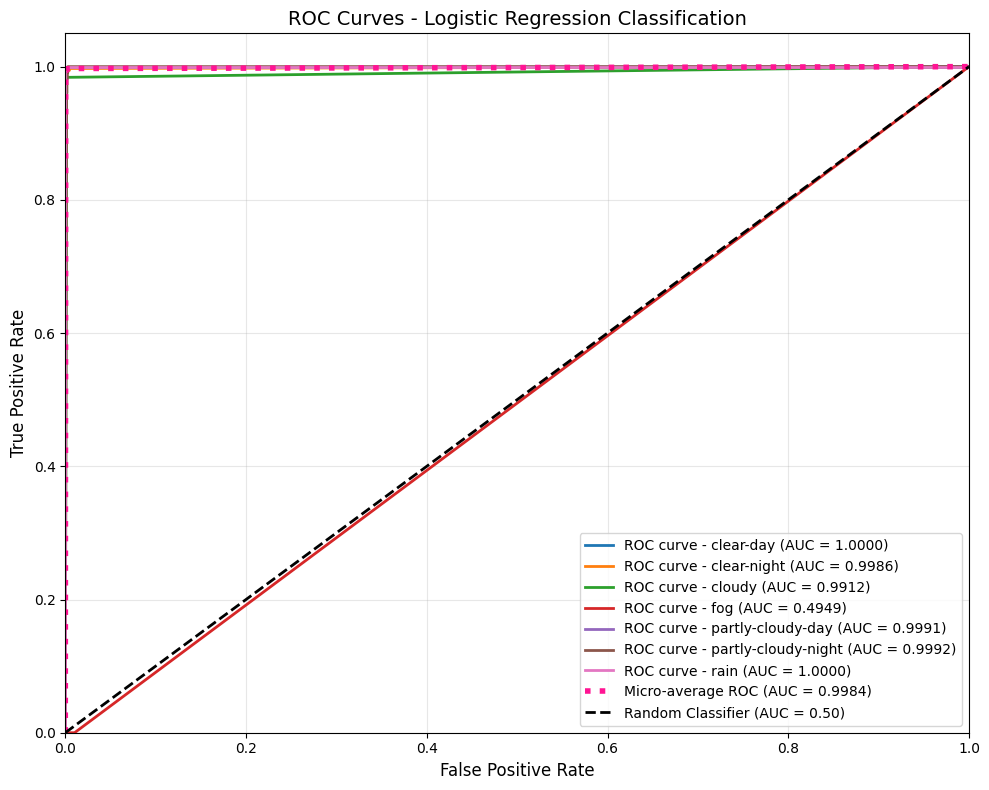

In [275]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [276]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9983
One-vs-One (Weighted)  : 0.9543
Micro-average          : 0.9984


In [277]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.991105 → 0.993158
   F1-Score: 0.991128 → 0.992481
   AUC (micro-avg): 0.997248 → 0.998368
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [278]:
base_model = RandomForestClassifier(random_state=42)
base_model

RandomForestClassifier(random_state=42)

In [279]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [280]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   58.1s remaining:   58.1s


CPU times: user 6.37 s, sys: 10.5 s, total: 16.9 s
Wall time: 1min 4s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [281]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.3s remaining:    9.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   19.3s finished


In [282]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [283]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9815
Precision: 0.9802
Recall:    0.9815
F1-Score:  0.9805


In [284]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.99      0.98      0.98       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.96      0.82      0.88       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.97      1.00      0.98       774
partly-cloudy-night       0.97      0.99      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.98      2923
          macro avg       0.84      0.82      0.83      2923
       weighted avg       0.98      0.98      0.98      2923



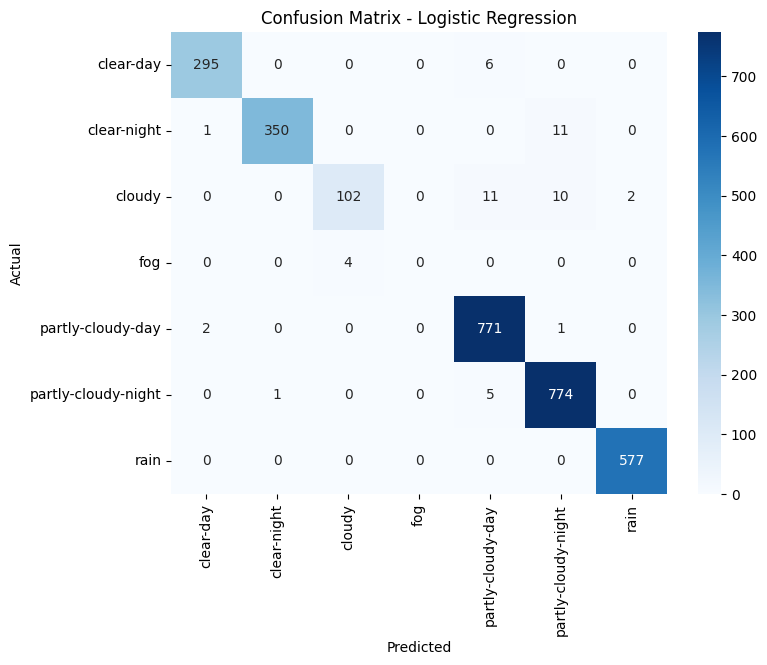

In [285]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [286]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.3s remaining:    8.3s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   13.8s finished


In [287]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [288]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9988
clear-night : 0.9993
cloudy   : 0.9966
fog      : 0.9947
partly-cloudy-day : 0.9992
partly-cloudy-night : 0.9987
rain     : 1.0000
Micro-avg : 0.9991


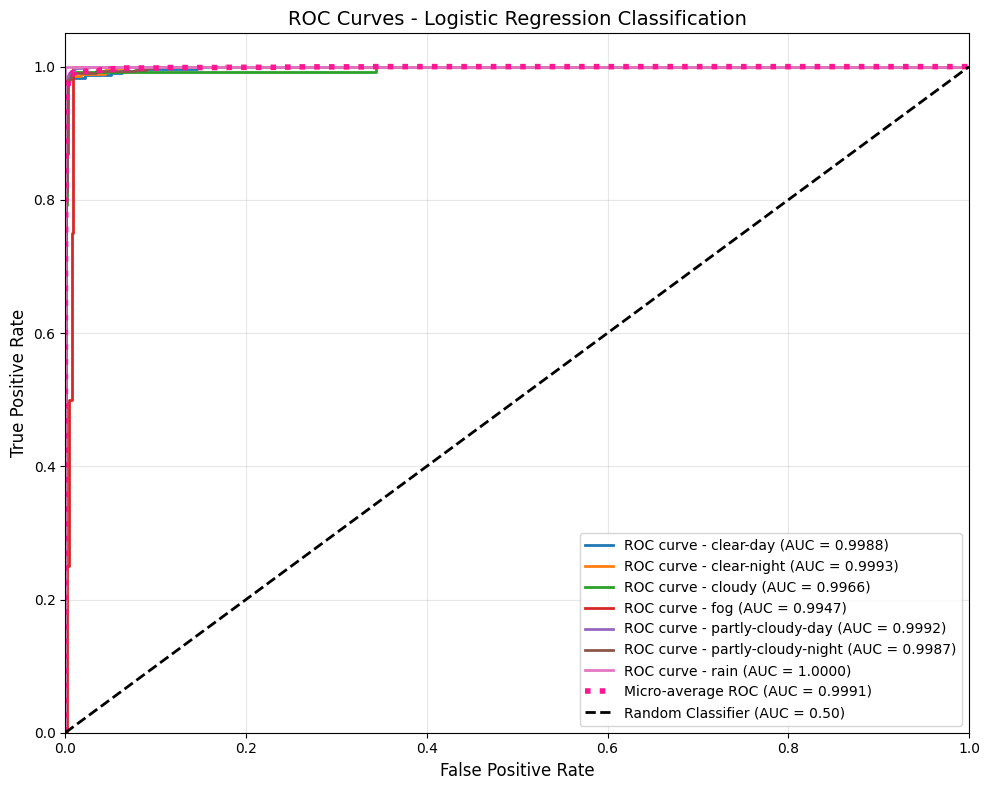

In [289]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [290]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9991
One-vs-One (Weighted)  : 0.9968
Micro-average          : 0.9991


In [291]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.987342 ≈ 0.981526 (similar)
   F1-Score: 0.986645 ≈ 0.980521 (similar)
   AUC (micro-avg): 0.999363 ≈ 0.999054
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


# All Performance

In [292]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
                Model         Scaler Target  Features Accuracy Precision   Recall F1-Score
   Random Forest Grid   MinMaxScaler   Icon        23 0.993158  0.991829 0.993158 0.992481
   Random Forest Grid StandardScaler   Icon        23 0.993158  0.991829 0.993158 0.992481
   Random Forest Grid   RobustScaler   Icon        23 0.993158  0.991829 0.993158 0.992481
        Random Forest   MinMaxScaler   Icon        23 0.990079  0.988799 0.990079 0.989394
        Random Forest StandardScaler   Icon        23 0.990079  0.988799 0.990079 0.989394
        Random Forest   RobustScaler   Icon        23 0.990079  0.988799 0.990079 0.989394
Random Forest Bagging   MinMaxScaler   Icon        23 0.981526  0.980225 0.981526 0.980521
Random Forest Bagging StandardScaler   Icon        23 0.981526  0.980225 0.981526 0.980521
Random Forest Bagging   RobustScaler   Icon        23 0.981526  0.980225 0.981526 0.980521

📈 Total models shown: 9
🏆 Best F1-Score: 0.99

# <center><font size="50" color="red">Thank You</font></center>